## Soumil Nitin Shah 
Bachelor in Electronic Engineering |
Masters in Electrical Engineering | 
Master in Computer Engineering |

* Website : http://soumilshah.com/
* Github: https://github.com/soumilshah1995
* Linkedin: https://www.linkedin.com/in/shah-soumil/
* Blog: https://soumilshah1995.blogspot.com/
* Youtube : https://www.youtube.com/channel/UC_eOodxvwS_H7x2uLQa-svw?view_as=subscriber
* Facebook Page : https://www.facebook.com/soumilshah1995/
* Email : shahsoumil519@gmail.com
* projects : https://soumilshah.herokuapp.com/project

* I earned a Bachelor of Science in Electronic Engineering and a double master’s in Electrical and Computer Engineering. I have extensive expertise in developing scalable and high-performance software applications in Python. I have a YouTube channel where I teach people about Data Science, Machine learning, Elastic search, and AWS. I work as data Team Lead at Jobtarget where I spent most of my time developing Ingestion Framework and creating microservices and scalable architecture on AWS. I have worked with a massive amount of data which includes creating data lakes (1.2T) optimizing data lakes query by creating a partition and using the right file format and compression. I have also developed and worked on a streaming application for ingesting real-time streams data via kinesis and firehose to elastic search

#### Goal
## How do i get get rid of duplicates and gurantee uniqueness across all partition

# Index Types in Hudi

* Bloom Index (default): Employs bloom filters built out of the record keys, optionally also pruning candidate files using record key ranges.

* Simple Index: Performs a lean join of the incoming update/delete records against keys extracted from the table on storage.
* HBase Index: Manages the index mapping in an external Apache HBase table.
* Bring your own implementation: You can extend this public API to implement custom indexing.


* Another key aspect worth understanding is the difference between global and non-global indexes. Both bloom and simple index have global options - hoodie.index.type=GLOBAL_BLOOM and hoodie.index.type=GLOBAL_SIMPLE - respectively. HBase index is by nature a global index.

#### Global index:
* Global indexes enforce uniqueness of keys across all partitions of a table i.e guarantees that exactly one record exists in the table for a given record key. Global indexes offer stronger guarantees, but the update/delete cost grows with size of the table O(size of table), which might still be acceptable for smaller tables.

#### Non Global index:
* On the other hand, the default index implementations enforce this constraint only within a specific partition. As one might imagine, non global indexes depends on the writer to provide the same consistent partition path for a given record key during update/delete, but can deliver much better performance since the index lookup operation becomes O(number of records updated/deleted) and scales well with write volume.


## Step 1: 
##### Define Imports 

In [1]:
try:

    import os
    import sys
    import uuid

    import pyspark
    from pyspark.sql import SparkSession
    from pyspark import SparkConf, SparkContext
    from pyspark.sql.functions import col, asc, desc
    from pyspark.sql.functions import col, to_timestamp, monotonically_increasing_id, to_date, when
    from pyspark.sql.functions import *
    from pyspark.sql.types import *
    from datetime import datetime
    from functools import reduce
    from faker import Faker


except Exception as e:
    pass

# Step 2:
#### Create Spark Instance 

In [2]:
SUBMIT_ARGS = "--packages org.apache.hudi:hudi-spark3.3-bundle_2.12:0.12.1 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('className', 'org.apache.hudi') \
    .config('spark.sql.hive.convertMetastoreParquet', 'false') \
    .getOrCreate()

In [3]:
spark

# Step 3: 
#### Definje Hudi Settings for this project 

In [35]:
db_name = "hudidb"
table_name = "hudi_table"

recordkey = 'uuid'
precombine = 'precomb'

path = f"file:///C:/tmp/{db_name}/{table_name}"

method = 'upsert'
table_type = "COPY_ON_WRITE"  # COPY_ON_WRITE | MERGE_ON_READ
partiton_field = "partition"


hudi_options = {
    'hoodie.table.name': table_name,
    'hoodie.datasource.write.recordkey.field': recordkey,
    'hoodie.datasource.write.table.name': table_name,
    'hoodie.datasource.write.operation': method,
    'hoodie.datasource.write.precombine.field': precombine,
    'hoodie.upsert.shuffle.parallelism': 2,
    'hoodie.insert.shuffle.parallelism': 2,
    'hoodie.datasource.write.partitionpath.field': partiton_field,
}

# Step 4:
#### Lets create out Hudidatalake and insert records and learn about precomb key

In [36]:
data_items = [
    (1, "mess 1",  111, 1),
    (2, "mes 2",  222, 2),
]

columns = ["uuid", "message", "precomb", "partition"]

spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)
df.select(["partition", "uuid", "precomb", "message", "_hoodie_commit_time", "_hoodie_commit_seqno"]).show(truncate=False)

+---------+----+-------+-------+-------------------+---------------------+
|partition|uuid|precomb|message|_hoodie_commit_time|_hoodie_commit_seqno |
+---------+----+-------+-------+-------------------+---------------------+
|1        |1   |111    |mess 1 |20230110205311306  |20230110205311306_0_0|
|2        |2   |222    |mes 2  |20230110205311306  |20230110205311306_1_0|
+---------+----+-------+-------+-------------------+---------------------+



# Adding one more data

In [37]:
data_items = [
    (1, "upt 1",  111, 1),
    (1, "upt 1",  111, 2),
]

columns = ["uuid", "message", "precomb", "partition"]

spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)
df.select(["partition", "uuid", "precomb", "message", "_hoodie_commit_time", "_hoodie_commit_seqno"]).show(truncate=False)

+---------+----+-------+-------+-------------------+---------------------+
|partition|uuid|precomb|message|_hoodie_commit_time|_hoodie_commit_seqno |
+---------+----+-------+-------+-------------------+---------------------+
|2        |2   |222    |mes 2  |20230110205311306  |20230110205311306_1_0|
|2        |1   |111    |upt 1  |20230110205428266  |20230110205428266_1_1|
|1        |1   |111    |upt 1  |20230110205428266  |20230110205428266_0_0|
+---------+----+-------+-------+-------------------+---------------------+



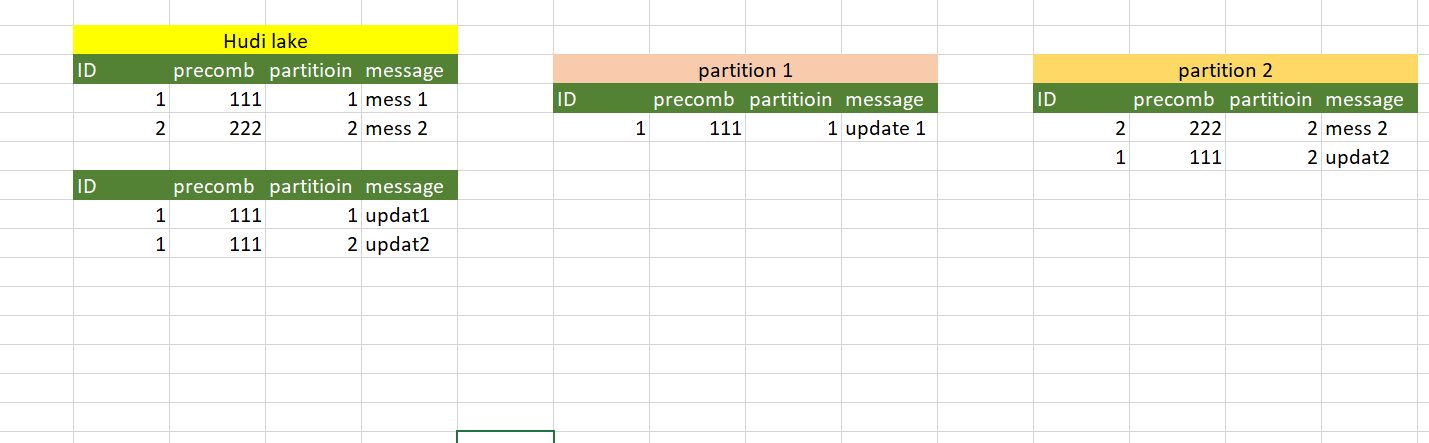

# Global Index 

In [38]:
db_name = "hudidb"
table_name = "hudi_table"

recordkey = 'uuid'
precombine = 'precomb'

path = f"file:///C:/tmp/{db_name}/{table_name}"

method = 'upsert'
table_type = "COPY_ON_WRITE"  # COPY_ON_WRITE | MERGE_ON_READ
partiton_field = "partition"


hudi_options = {
    'hoodie.table.name': table_name,
    'hoodie.datasource.write.recordkey.field': recordkey,
    'hoodie.datasource.write.table.name': table_name,
    'hoodie.datasource.write.operation': method,
    'hoodie.datasource.write.precombine.field': precombine,
    'hoodie.upsert.shuffle.parallelism': 2,
    'hoodie.insert.shuffle.parallelism': 2,
    "hoodie.index.type":"GLOBAL_BLOOM",
    'hoodie.datasource.write.partitionpath.field': partiton_field,
}

In [39]:
data_items = [
    (1, "mess 1",  111, 1),
    (2, "mes 2",  222, 2),
]

columns = ["uuid", "message", "precomb", "partition"]

spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)
df.select(["partition", "uuid", "precomb", "message", "_hoodie_commit_time", "_hoodie_commit_seqno"]).show(truncate=False)

+---------+----+-------+-------+-------------------+---------------------+
|partition|uuid|precomb|message|_hoodie_commit_time|_hoodie_commit_seqno |
+---------+----+-------+-------+-------------------+---------------------+
|1        |1   |111    |mess 1 |20230110205624296  |20230110205624296_0_0|
|2        |2   |222    |mes 2  |20230110205624296  |20230110205624296_1_0|
+---------+----+-------+-------+-------------------+---------------------+



# Append 2

In [40]:
data_items = [
    (1, "upt 1",  111, 1),
    (1, "upt 1",  111, 2),
]

columns = ["uuid", "message", "precomb", "partition"]

spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)
df.select(["partition", "uuid", "precomb", "message", "_hoodie_commit_time", "_hoodie_commit_seqno"]).show(truncate=False)

+---------+----+-------+-------+-------------------+---------------------+
|partition|uuid|precomb|message|_hoodie_commit_time|_hoodie_commit_seqno |
+---------+----+-------+-------+-------------------+---------------------+
|2        |2   |222    |mes 2  |20230110205624296  |20230110205624296_1_0|
|2        |1   |111    |upt 1  |20230110205705586  |20230110205705586_1_1|
+---------+----+-------+-------+-------------------+---------------------+

